<a href="https://colab.research.google.com/github/ninemoonz/deepLearning/blob/main/%08Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis
- Applied on stock price prediction, temperature (weather), and etc

In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

SEED = 12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Google drive mount
from google.colab import drive, files
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [80]:
# data download
drive_path='/gdrive/My Drive/'
smp = pd.read_csv(drive_path + "smp/SMP.csv", encoding='CP949')

# turn the date data into time series form
smp['date'] = pd.to_datetime(smp['기간'])
smp['max'] = smp['최대']
smp['min'] = smp['최소']
smp['smp_mean'] = smp['가중평균']
smp['day_of_week'] = smp['date'].dt.dayofweek

smp.sort_values(by=['date'], inplace=True, ascending=True)

print(smp.shape)
smp.head()

(820, 33)


,기간,01시,02시,03시,04시,05시,06시,07시,08시,09시,...,23시,24시,최대,최소,가중평균,date,max,min,smp_mean,day_of_week
819,2020/01/01,86.20,84.03,82.76,82.52,80.74,81.90,80.95,80.51,82.49,...,82.13,83.95,86.20,77.83,81.46,2020-01-01,86.20,77.83,81.46,2
818,2020/01/02,80.67,82.60,79.44,79.04,82.60,80.15,82.60,86.65,89.32,...,84.10,84.10,89.68,79.04,85.51,2020-01-02,89.68,79.04,85.51,3
817,2020/01/03,83.00,81.71,82.60,81.26,81.31,82.60,88.46,88.75,89.04,...,82.49,84.07,89.84,81.26,85.63,2020-01-03,89.84,81.26,85.63,4
816,2020/01/04,83.69,81.58,82.58,81.17,81.17,82.95,83.72,84.60,84.59,...,83.84,83.99,84.60,79.39,83.26,2020-01-04,84.60,79.39,83.26,5
815,2020/01/05,87.41,87.30,81.70,78.87,78.92,80.76,80.67,80.62,81.90,...,82.20,82.31,87.41,78.55,81.95,2020-01-05,87.41,78.55,81.95,6


In [81]:
#Onehot Encoding
smp['day_of_week'] = smp['day_of_week'].astype('category')
smp = pd.get_dummies(smp, columns =['day_of_week'], prefix='W', drop_first=True)

smp.head()

,기간,01시,02시,03시,04시,05시,06시,07시,08시,09시,...,date,max,min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
819,2020/01/01,86.20,84.03,82.76,82.52,80.74,81.90,80.95,80.51,82.49,...,2020-01-01,86.20,77.83,81.46,0,1,0,0,0,0
818,2020/01/02,80.67,82.60,79.44,79.04,82.60,80.15,82.60,86.65,89.32,...,2020-01-02,89.68,79.04,85.51,0,0,1,0,0,0
817,2020/01/03,83.00,81.71,82.60,81.26,81.31,82.60,88.46,88.75,89.04,...,2020-01-03,89.84,81.26,85.63,0,0,0,1,0,0
816,2020/01/04,83.69,81.58,82.58,81.17,81.17,82.95,83.72,84.60,84.59,...,2020-01-04,84.60,79.39,83.26,0,0,0,0,1,0
815,2020/01/05,87.41,87.30,81.70,78.87,78.92,80.76,80.67,80.62,81.90,...,2020-01-05,87.41,78.55,81.95,0,0,0,0,0,1


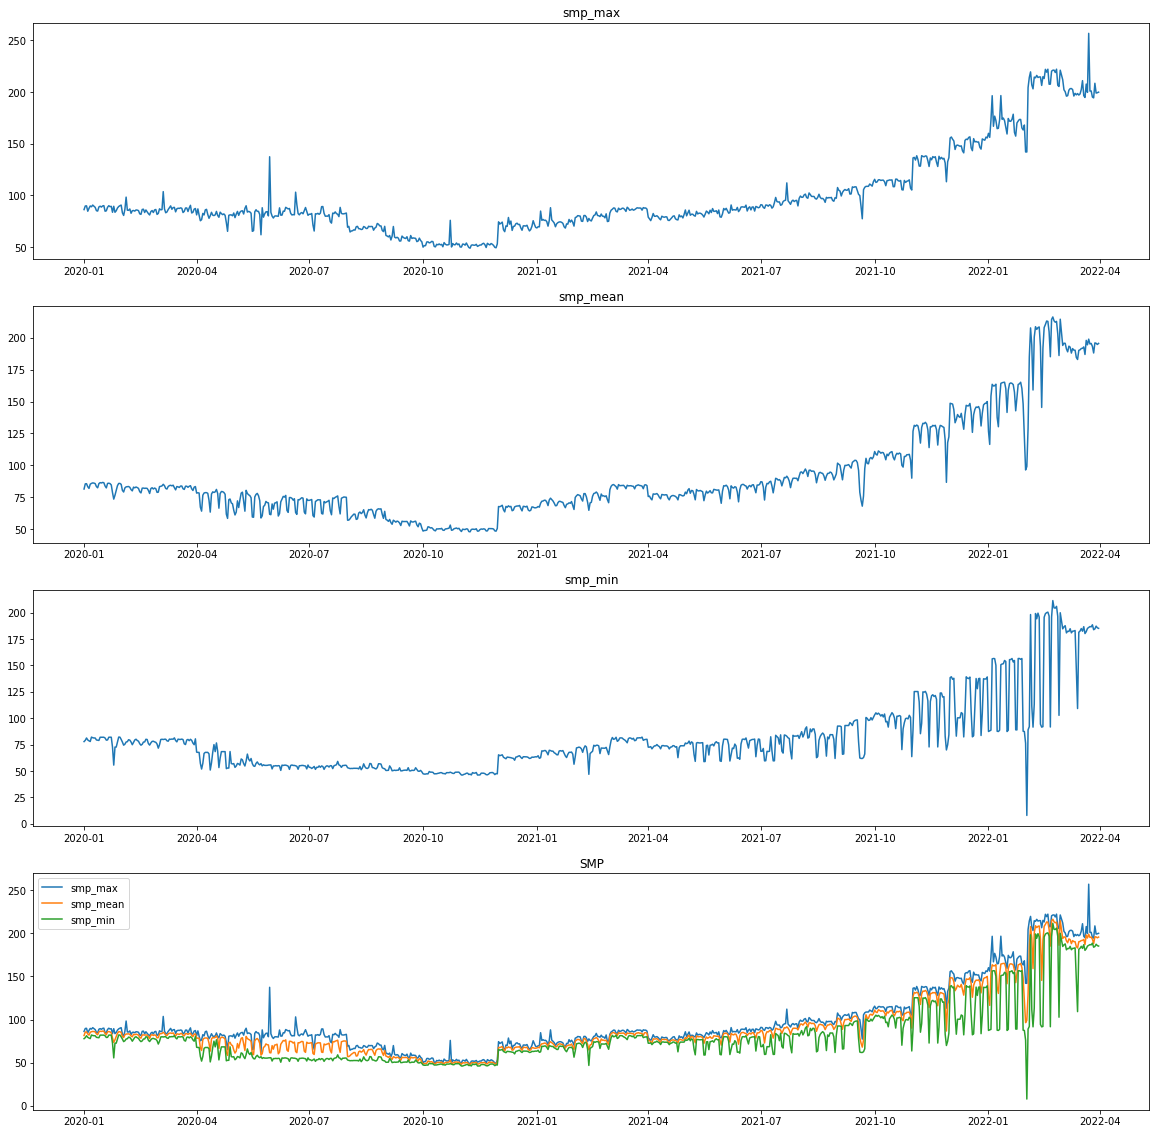

In [82]:
# Graph
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

axes[0].plot(smp['date'], smp['max'])
axes[0].set_title('smp_max')

axes[1].plot(smp['date'], smp['smp_mean'])
axes[1].set_title('smp_mean')

axes[2].plot(smp['date'], smp['min'])
axes[2].set_title('smp_min')

axes[3].plot(smp['date'], smp['max'], label='smp_max')
axes[3].plot(smp['date'], smp['smp_mean'], label='smp_mean')
axes[3].plot(smp['date'], smp['min'], label='smp_min')
axes[3].set_title('SMP')
axes[3].legend()

plt.show()

## 5-2 Data Pre-processing

In [83]:
# Settings
train_split_idx = 729 #2020-03-31까지의 데이터
window_size = 10 # past 10 days
future = 3 # 3 days after to guess

x_train = smp.iloc[:train_split_idx - window_size - future, 0:]

y_train = smp.iloc[window_size + future :train_split_idx, [-7]]

print(x_train.shape, y_train.shape)

(716, 38) (716, 1)


In [84]:
x_train.head(20)

,기간,01시,02시,03시,04시,05시,06시,07시,08시,09시,...,date,max,min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
819,2020/01/01,86.20,84.03,82.76,82.52,80.74,81.90,80.95,80.51,82.49,...,2020-01-01,86.20,77.83,81.46,0,1,0,0,0,0
818,2020/01/02,80.67,82.60,79.44,79.04,82.60,80.15,82.60,86.65,89.32,...,2020-01-02,89.68,79.04,85.51,0,0,1,0,0,0
817,2020/01/03,83.00,81.71,82.60,81.26,81.31,82.60,88.46,88.75,89.04,...,2020-01-03,89.84,81.26,85.63,0,0,0,1,0,0
816,2020/01/04,83.69,81.58,82.58,81.17,81.17,82.95,83.72,84.60,84.59,...,2020-01-04,84.60,79.39,83.26,0,0,0,0,1,0
815,2020/01/05,87.41,87.30,81.70,78.87,78.92,80.76,80.67,80.62,81.90,...,2020-01-05,87.41,78.55,81.95,0,0,0,0,0,1
814,2020/01/06,82.30,80.31,78.87,77.92,79.00,82.10,81.22,87.88,89.70,...,2020-01-06,89.70,77.92,85.24,0,0,0,0,0,0
813,2020/01/07,83.40,82.60,82.60,82.09,82.60,82.31,84.57,88.55,88.94,...,2020-01-07,88.94,82.09,85.88,1,0,0,0,0,0
812,2020/01/08,83.41,82.60,82.55,81.50,82.09,82.60,87.75,89.87,89.95,...,2020-01-08,90.57,81.50,86.24,0,1,0,0,0,0
811,2020/01/09,83.25,87.18,87.18,81.24,81.92,81.92,83.24,84.09,88.66,...,2020-01-09,89.47,81.24,86.10,0,0,1,0,0,0
810,2020/01/10,83.28,82.60,81.25,81.23,82.97,82.97,82.97,84.41,88.30,...,2020-01-10,88.36,81.23,85.72,0,0,0,1,0,0


In [85]:
y_train.head()

,smp_mean
806,86.48
805,86.21
804,86.62
803,86.41
802,83.82


In [86]:
# x_test
test_start = train_split_idx - window_size - future # test data 시작 행
test_end = smp.shape[0] - window_size - future
x_test = smp.iloc[test_start:test_end, 0:]

# y_test
# label_start = + future # place of first target data of test data
y_test = smp.iloc[train_split_idx:,[-7]]

print(x_test.shape, y_test.shape)

(91, 38) (91, 1)


In [87]:
x_test.head(15)

,기간,01시,02시,03시,04시,05시,06시,07시,08시,09시,...,date,max,min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
103,2021/12/17,146.35,146.53,138.95,138.95,138.95,140.21,145.84,149.22,156.68,...,2021-12-17,156.68,138.95,148.52,0,0,0,1,0,0
102,2021/12/18,145.88,140.47,140.55,137.50,138.86,140.75,144.71,144.71,144.71,...,2021-12-18,145.99,105.89,141.81,0,0,0,0,1,0
101,2021/12/19,139.48,137.14,116.77,108.21,108.21,116.77,138.95,138.95,138.94,...,2021-12-19,143.24,82.34,125.86,0,0,0,0,0,1
100,2021/12/20,132.68,104.89,83.69,83.45,104.89,104.89,146.37,149.61,149.56,...,2021-12-20,154.93,83.45,139.70,0,0,0,0,0,0
99,2021/12/21,140.67,140.02,138.87,111.72,136.13,139.72,145.27,147.43,151.73,...,2021-12-21,151.73,111.72,143.83,1,0,0,0,0,0
98,2021/12/22,140.85,138.23,137.78,137.61,138.21,139.63,149.05,148.78,152.17,...,2021-12-22,152.17,137.61,145.72,0,1,0,0,0,0
97,2021/12/23,141.84,137.97,127.94,132.95,135.74,139.55,144.79,148.71,151.55,...,2021-12-23,151.55,127.94,145.43,0,0,1,0,0,0
96,2021/12/24,140.64,139.31,137.94,137.50,138.23,140.41,145.29,149.53,151.68,...,2021-12-24,151.68,137.50,146.10,0,0,0,1,0,0
95,2021/12/25,145.32,145.50,146.49,140.33,140.40,140.54,143.36,145.44,146.49,...,2021-12-25,146.56,137.77,143.51,0,0,0,0,1,0
94,2021/12/26,140.17,138.64,132.68,112.77,112.83,132.59,144.77,142.91,144.77,...,2021-12-26,144.77,83.62,130.87,0,0,0,0,0,1


In [88]:
y_test.head()

,smp_mean
90,148.80
89,150.00
88,126.81
87,116.43
86,154.25


In [89]:
#Feature Scaling
x_train_scaled = x_train.loc[:, 'max':]
x_test_scaled = x_test.loc[:, 'max':]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(x_train_scaled.values)
x_train_scaled.loc[:, :] = scaler.transform(x_train_scaled.values)
x_test_scaled.loc[:, :] = scaler.transform(x_test_scaled.values)

In [90]:
# Mini Batch size

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
train_data = timeseries_dataset_from_array(x_train_scaled, y_train, sequence_length=window_size, batch_size=16)

test_data = timeseries_dataset_from_array(x_test_scaled, y_test, sequence_length=window_size, batch_size=16)

print(train_data)
print(test_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [91]:
for batch in test_data.take(1):
  inputs, targets = batch 

print('Input: ', inputs.numpy().shape)
print('Target: ', targets.numpy().shape)

Input:  (16, 10, 9)
Target:  (16, 1)


In [92]:
inputs[0]

<tf.Tensor: shape=(10, 9), dtype=float64, numpy=
array([[1.00176449, 0.9966706 , 0.99851117, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.90248886, 0.6416067 , 0.93191067, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.87695022, 0.38868006, 0.77359801, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.98551263, 0.40060144, 0.91096774, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.95579495, 0.70422081, 0.9519603 , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.95988113, 0.98227902, 0.9707196 , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.95412333, 0.87842337, 0.96784119, 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.95533061, 0.98109763, 0.97449132, 0.        , 0.        ,
        

In [93]:
targets[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([148.8])>

## 5-3 Predicting Time series with LSTM Model


In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential()
model.add(Input(shape=[10, 9]))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                5376      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


In [95]:
# model training
history = model.fit(train_data, epochs=500, validation_data=test_data, verbose=0)

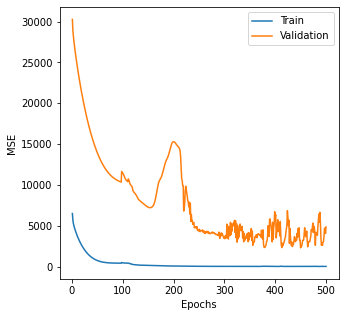

In [96]:
#Loss Function Graph
def plot_loss_curve(history, total_epoch=10, start=1):
  plt.figure(figsize=(5,5))
  plt.plot(range(start, total_epoch + 1), history.history['loss'][start-1:total_epoch], label='Train')
  plt.plot(range(start, total_epoch + 1), history.history['val_loss'][start-1:total_epoch], label='Validation')

  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

plot_loss_curve(history=history, total_epoch=len(history.history['loss']), start=1)
  

In [97]:
y_pred = model.predict(test_data)
y_pred.shape

(82, 1)

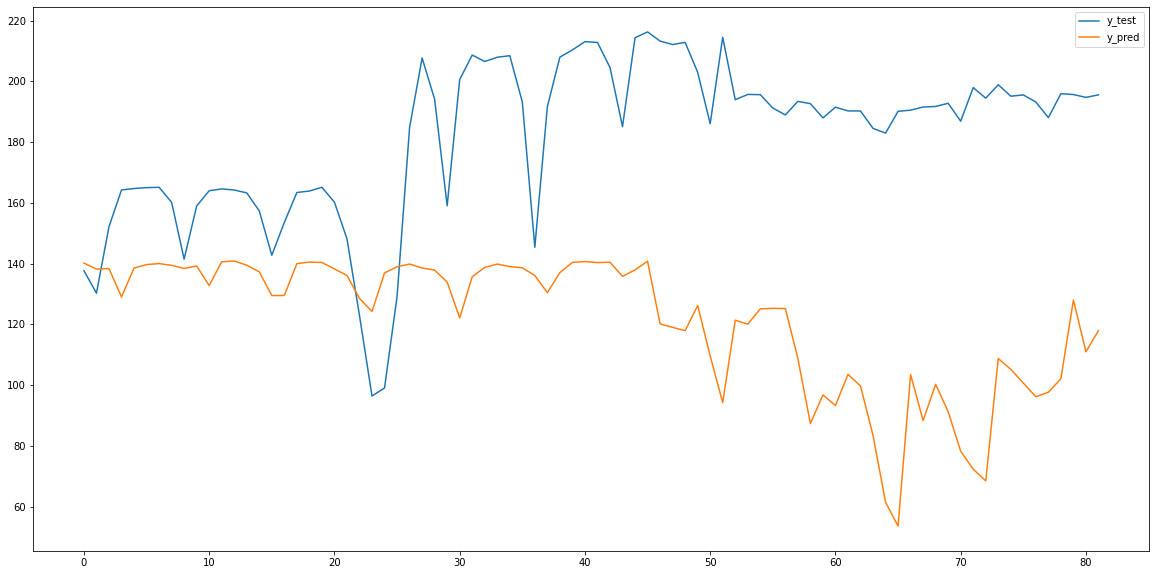

In [98]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(y_pred)), y_test[window_size-1:], label='y_test')
plt.plot(range(len(y_pred)), y_pred, label='y_pred')
plt.legend()
plt.show()